# Generalization and Model Complexity


### Machine Learning and Computational Statistics (DSC6135)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import cm

### latex definitions in this cell
$\def \w {\boldsymbol{w}}$
$\def \x {\boldsymbol{x}}$
$\def \y {\boldsymbol{y}}$

## Objectives

**Goal**: How can we learn functions that generalize well to unseen data?

* Cross-validation
    
* Bias-variance Decomposition
    
* Regularization

* Ensembles

* Bayesian perspective
    
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_toy_data(n_points=20, noise_std=0.25):
    np.random.seed(5)
    x = np.linspace(-5,5,n_points)
    y = 0.01 * x**3
    y = y + noise_std*np.random.randn(n_points)
    return x,y

def plot_toy_data(x,y):
    K = 4
    fig, ax = plt.subplots(1,4,figsize=(16,4),sharey=True)
    for k in range(K):
        ax[k].set_xlabel('x')
    ax[0].scatter(x,y)
    ax[0].set_title('Available data')
    ax[1].set_title("Poly=2")
    ax[2].set_title("Poly=4")
    ax[3].set_title("Poly=16")
    ax[0].set_ylabel('y')
    return fig, ax

## 0. Connecting with last lecture...

* k-nearest neighbors regression
* linear regression
* polynomial regression

Text(0, 0.5, 'y')

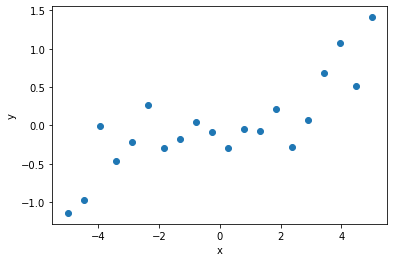

In [3]:
x_obs,y_obs = generate_toy_data(n_points=20)
plt.scatter(x_obs,y_obs)
plt.xlabel('x')
plt.ylabel('y')

## k-nearest neighbors from scratch

In [4]:
def predict_knn_regression(x, x_observed, y_observed, k=1):
    '''
    Function to predict output y for input x given past data (x_observed, y_observed) in 1-dimension
    '''
    def compute_square_error(x_obs,x_star): return (x_obs - x_star)**2
    N_obs = x_observed.shape[0]
    N_to_predict = x.shape[0]
    y = np.zeros(N_to_predict)
    for n in range(N_to_predict):
        distance_vector = np.array([compute_square_error(x_obs,x[n]) for x_obs in x_observed])
        sorted_distances,idxs_neigh = [np.array(x) for x in zip( *sorted(zip(distance_vector,range(N_obs))) )]
        y[n] = np.mean(y_observed[idxs_neigh[:k]])
    return y
predict_knn_regression(np.array([1,2,3]),x_obs,y_obs)

array([-0.04629859,  0.21337701,  0.06751975])

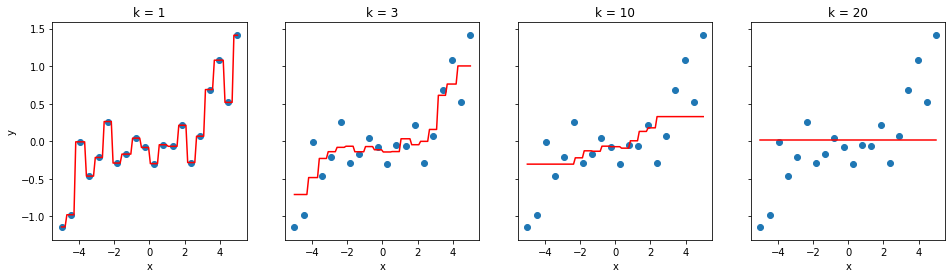

In [5]:
## LET'S RUN K-NN REGRESSION FOR OUR TRAINING DATA WITH k=1, k=3, and k=10 neighbors
fig,ax = plt.subplots(1,4,figsize=(16,4),sharey=True)
ax[0].set_ylabel('y')
for i in range(4):
    ax[i].scatter(x_obs,y_obs)
    ax[i].set_xlabel('x')
x_grid = np.linspace(-5,5,100)
k_vec = np.array([1,3,10,20])
for ax_id, k in enumerate(k_vec):
    y_grid = predict_knn_regression(x_grid,x_obs,y_obs,k=k)
    ax[ax_id].plot(x_grid,y_grid,'r')
    ax[ax_id].set_title('k = %d' % k)

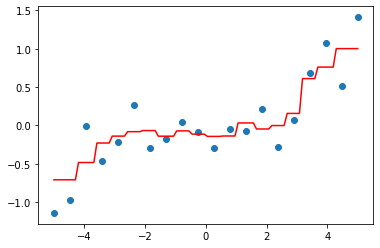

In [6]:
# K-NN implementation using sklearn library
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(x_obs[:,np.newaxis],y_obs[:,np.newaxis])
n_points = 100
x_grid = np.linspace(-5,5,n_points)[:,np.newaxis]
y_grid = knn_regressor.predict(x_grid)

# PLOT predicted function (x,y) by KNN regressor
f,ax = plt.subplots()
ax.scatter(x_obs,y_obs)
ax.plot(x_grid,y_grid,'r')

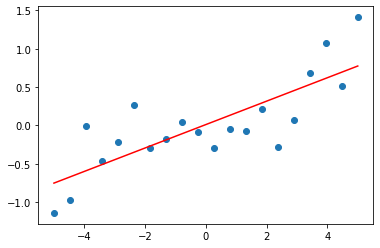

In [7]:
# Linear Regression implementation using sklearn library
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
linear_regressor.fit(x_obs[:,np.newaxis],y_obs[:,np.newaxis])
n_points = 100
x_grid = np.linspace(-5,5,n_points)[:,np.newaxis]
y_grid = linear_regressor.predict(x_grid)

f,ax = plt.subplots()
ax.scatter(x_obs,y_obs)
ax.plot(x_grid,y_grid,'r')

In [8]:
# Polynomial Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# How to use PolynomialFeatures class?
# poly = PolynomialFeatures(2)
# x_transform = poly.fit_transform(x)

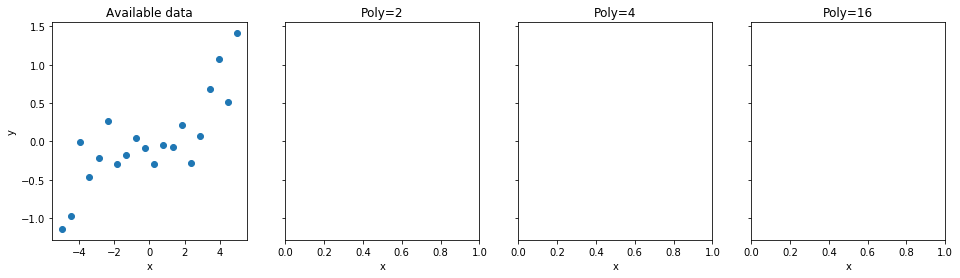

In [9]:
# QUESTION: Fit Polynomial regressors with degrees equal to 2, 4, and 16
fig, ax = plot_toy_data(x_obs,y_obs)
## WRITE

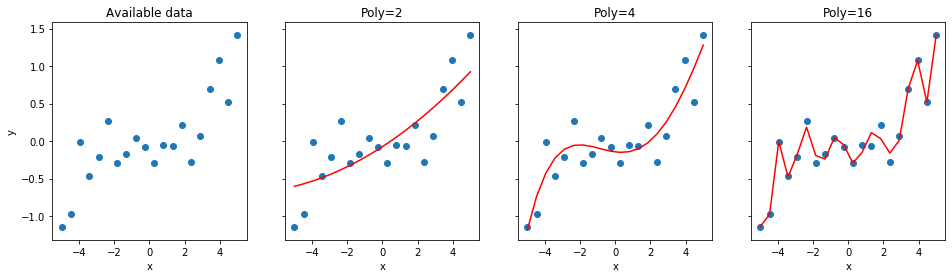

In [10]:
# SOLUTION: Fit Polynomial regressors with degrees equal to 2, 4, and 16 
fig, ax = plot_toy_data(x_obs,y_obs)
poly_vec = np.array([2,4,16])
for ax_id, p in enumerate(poly_vec):
    poly = PolynomialFeatures(p)
    x_transform = poly.fit_transform(x_obs[:,np.newaxis])
    linear_reg = LinearRegression()
    linear_reg.fit(x_transform,y_obs)
    y_predict = linear_reg.predict(x_transform)
    ax[ax_id+1].scatter(x_obs,y_obs)
    ax[ax_id+1].plot(x_obs,y_predict,'r')

## 1. Introduction to Generalization

* How to choose model parameters (example: number of neighbors, or polynomial degree?)

* Which function is better?

* In the following, we will learn:
    * how to *identify* (evaluate) the model that generalizes the best
    * how to optimize models to generalize well

### What can we do to get models that generalize well?

* Validation: rely on train/test set

* Regularization

* Ensembles

## 2. Validation and Test

<table><tr><td><img src="figs/02_model_selection/ms5.png" width="80%"></td><td><img src="figs/02_model_selection/ms6.png" width="80%"></td></tr></table>

* red points: training set
* green points: test set (where we evaluate)

We want to *generalize well*, not just predict the training set well.

## We need to split into train and test

<img src="figs/02_model_selection/split.png" width="55%">

## How to fit best model?

<img src="figs/02_model_selection/ms_how1.png" width="80%">

(slide M. Hughes)

## How to fit best model?

<img src="figs/02_model_selection/ms_how2.png" width="80%">

(slide M. Hughes)

## How to fit best model?

<img src="figs/02_model_selection/ms_how3.png" width="80%">

(slide M. Hughes)

### Cross-validation

* Split dataset in A, B, C, D chunks

* Hold out D, train on A, B, C

* Hold out C, train on A, B, D, etc...

### Exercise: Interpreting the likelihood function

Say we're considering two linear models for the dataset $\{(1, 2), (2, 3)\}$ with iid noise $\epsilon_n \sim \mathcal{N}(0, 1)$.

1. Model 1: $y = x + 2$
2. Model 2: $y = 2 - 2x$

Which model, assuming one is correct, is more appropriate for the data?

In [10]:
# SOLUTION
from scipy.stats import norm
#data
x_train = np.array([1, 2])
y_train = np.array([2, 3])

#likelihood functions
lkhd = lambda m, b: norm(m * x_train[0] + b, 1).pdf(y_train[0]) * norm(m * x_train[1] + b, 1).pdf(y_train[1])
print('likelihood of data under model 1:', np.round(lkhd(1, 2), 7))
print('likelihood of data under model 2:', np.round(lkhd(-2, 2), 7))

likelihood of data under model 1: 0.0585498
likelihood of data under model 2: 1e-07


## Model Complexity vs Error

<img src="figs/02_model_selection/complexity.png" width="80%">

In [11]:
def plot_bias_variance():
    Xs = np.arange(0, 10, 0.1)
    plt.plot(Xs, 0.0002 * np.exp(Xs), label='bias')
    plt.plot(Xs, 1 / np.sqrt(Xs), label='variance')
    #plt.plot(Xs, 0.5 * np.sqrt(Xs), label='variance')
    plt.ylabel('Error')
    plt.xlabel(r'$\lambda$')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    plt.legend()

## 3. Bias-variance Trade-off

**Definitions**:

* $\theta$: model parameters

$$\textrm{bias}(\theta) = \mathbb{E}[\theta] - \theta$$

$$\textrm{variance}(\theta) = \mathbb{E}[(\theta - \mathbb{E}[\theta])^2]$$

* Let us refer to model complexity as $\lambda$

In [12]:
## Derivation of Bias-Variance Decomposition

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


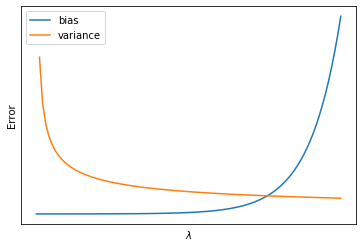

In [13]:
plot_bias_variance()

## Some intuition...

$$\textrm{bias}(\theta) = \mathbb{E}[\theta] - \theta$$

$$\textrm{variance}(\theta) = \mathbb{E}[(\theta - \mathbb{E}[\theta])^2]$$

<img src="figs/02_model_selection/bias_variance.png" width="70%">

## Derivation of Bias-Variance Decomposition

Making it more formal... let us write the mean square error as:

$$\mathbb{E}[(y- \hat{y})^2]$$

(see blackboard)

Let's begin by asserting that we have a model $f(\cdot)$ that makes a prediction of our target $y$ given input data point $\textbf{x}$. We wish to break down the squared error of $f$ into terms involving bias and variance. \\

Start with the expected squared error (MSE):
    \begin{align*}
        \textit{MSE} = \mathrm{E}[(y - f(\textbf{x}))^{2}]
    \end{align*}
    
    
For reasons that will become clear in a few steps, add and subtract our target mean $\bar{y}$, which is the true conditional mean given by $\bar{y} = \mathrm{E}_{y|\textbf{x}}[y]$, inside of the squared term:
    \begin{align*}
        \textit{MSE} = \mathrm{E}[(y - \bar{y} + \bar{y} - f(\textbf{x}))^{2}]
    \end{align*}
    Group together the first two terms and the last two terms:
    \begin{align*}
        \textit{MSE} = \mathrm{E}[((y - \bar{y}) + (\bar{y} - f(\textbf{x})))^{2}]
    \end{align*}
    Expanding this expression and using linearity of expectation:
    \begin{equation} \label{bias-variance-intermediate-1}
        \textit{MSE} = \mathrm{E}[(y - \bar{y})^{2}] + \mathrm{E}[(\bar{y} - f(\textbf{x}))^{2}] + 2\mathrm{E}[(y - \bar{y})(\bar{y} - f(\textbf{x}))]
    \end{equation}
    Let's examine the last term, $2\mathrm{E}[(y - \bar{y})(\bar{y} - f(\textbf{x}))]$. Notice that $(\bar{y} - f(\textbf{x}))$ does not depend on the conditional distribution $y|\textbf{x}$ at all. Thus, we are able to move one of those expecations in, which makes this term:
    \begin{align*}
        2\mathrm{E}[(y - \bar{y})(\bar{y} - f(\textbf{x}))] = 2\mathrm{E}_{D}[\mathrm{E}_{y|\textbf{x}}[(y - \bar{y})](\bar{y} - f(\textbf{x}))]
    \end{align*}
    And note that:
    \begin{align*}
        \mathrm{E}_{y|\textbf{x}}[(y - \bar{y})] = 0
    \end{align*}
    Which eliminates this last term entirely:
    \begin{align*}
        2\mathrm{E}[(y - \bar{y})(\bar{y} - f(\textbf{x}))] = 2\mathrm{E}_{D}[0 \cdot (\bar{y} - f(\textbf{x}))] = 0
    \end{align*}
    
We can now write the MSE as:
    \begin{equation} \label{bias-variance-intermediate-2}
        \textit{MSE} = \mathrm{E}[(y - \bar{y})^{2}] + \mathrm{E}[(\bar{y} - f(\textbf{x}))^{2}]
    \end{equation}
    
We now have two terms contributing to our squared error. We will ignore the first term $\mathrm{E}[(y - \bar{y})^{2}]$, as this is unidentifiable *noise* in our data set. In other words, our data will randomly deviate from the mean in ways we cannot predict. On the other hand, we can work with the second term $\mathrm{E}[(\bar{y} - f(\textbf{x}))^{2}]$ as it involves our model function $f(\cdot)$

As before, for reasons that will become clear in a few steps, let's add and subtract our prediction mean $\bar{f}(\cdot) = \mathrm{E}_{D}[f(\textbf{x})]$, which is the expectation of our model function taken with respect to our random data set.
    \begin{align*}
        \mathrm{E}[(\bar{y} - f(\textbf{x}))^{2}] = \mathrm{E}[(\bar{y} - \bar{f}(\textbf{x}) + \bar{f}(\textbf{x}) - f(\textbf{x}))^{2}]
    \end{align*}
    Expanding this squared term, we have:
    \begin{align*}
        \mathrm{E}[(\bar{y} - f(\textbf{x}))^{2}] = (\bar{y} - \bar{f}(\textbf{x}))^{2} + \mathrm{E}[(\bar{f}(\textbf{x}) - f(\textbf{x}))^{2}] + 2\mathrm{E}[(\bar{y} - \bar{f}(\textbf{x}))(\bar{f}(\textbf{x}) - f(\textbf{x}))]
    \end{align*}

As before, the third term here is 0:
    \begin{align*}
        2\mathrm{E}[(\bar{y} - \bar{f}(\textbf{x}))(\bar{f}(\textbf{x}) - f(\textbf{x}))] = 2(\bar{y} - \bar{f}(\textbf{x}))\mathrm{E}[(\bar{f}(\textbf{x}) - f(\textbf{x}))] = 2(\bar{y} - \bar{f}(\textbf{x}))(0) = 0
    \end{align*}
    Leaving us with these two terms:
    \begin{align*}
        \mathrm{E}[(\bar{y} - f(\textbf{x}))^{2}] = (\bar{y} - \bar{f}(\textbf{x}))^{2} + \mathrm{E}[(\bar{f}(\textbf{x}) - f(\textbf{x}))^{2}]
    \end{align*}

Notice the form of these two terms. The first one, $(\bar{y} - \bar{f}(\textbf{x}))^{2}$, is the squared \textit{bias} of our model, since it is the square of the average difference between our prediction and the true target value. The second one, $\mathrm{E}[(\bar{f}(\textbf{x}) - f(\textbf{x}))^{2}]$, is the \textit{variance} of our model, since it is the expected squared difference between our model and its average value. Thus:
    \begin{align*}
        \mathrm{E}[(y - f(\textbf{x}))^{2}] = \textit{bias}(f(\textbf{x}))^{2} + \textit{variance}(f(\textbf{x}))
    \end{align*}

Thus, our total squared error, plugging in to the MSE Equation can be written as:
    \begin{align*}
        \boxed{\textit{MSE} = \textit{noise}(\textbf{x}) + \textit{bias}(f(\textbf{x}))^{2} + \textit{variance}(f(\textbf{x}))}
    \end{align*}

## Derivation of Bias-Variance Decomposition

Putting it all together...

\begin{align*}
\textit{MSE} = \textit{noise}(\textbf{x}) + \textit{bias}(f(\textbf{x}))^{2} + \textit{variance}(f(\textbf{x}))
 \end{align*}

**Bias-Variance Tradeoﬀ**: When constructing machine learning models, we have a choice somewhere on a spectrum between two extremes: ﬁtting exactly to our training data or not varying in response to our training data at all. The ﬁrst extreme, ﬁtting all of our training data, is a situation of high variance, because our output changes heavily in reponse to our input data. At the other extreme, a solution that doesn’t change in response to our training data at all is a situation of high bias. This means our model heavily favors a speciﬁc form regardless of the training data, so our target outputs don’t ﬂuctuate between distinct training sets.

# What can we do to get models that generalize well?

* Validation: rely on train/test set

* Regularization

* Ensembles

## 4. Regularization

**Idea**: assign a penalty on model complexity by constraining norm of weights 

* Ridge regression (L2-norm penalization)

    $$min \mathcal{L}(\mathbf{w}) + \lambda || \mathbf{w} ||_2^2$$
    
* Lasso regression (L1-norm penalization)

    $$min \mathcal{L}(\mathbf{w}) + \lambda || \mathbf{w} ||_1$$

$\lambda$ can be chosen via validation/cross-validation.

## 5. Ensembles

**Idea**: use an *ensemble* of models and take the average (regression).

* *Bagging* or bootstrap aggregation: train an ensemble of models by re-sampling data with replacement. 


* *Boosting*: train models to give more weights to incorrect examples; weight votes based on accuracy.

### Exercise: Bagging
In the following we will implement bagging:
1. we will train a large ensemble of complex models on bootstrap samples of training data
2. we will average the predictions of the models in our ensemble to reduce the variance in the prediction.

In [27]:
def make_data(number_of_train_points, number_of_test_points, f):
    '''
    This function randomly samples training data in [-5, 5], given a function f.
    
    number_of_train_points: number of training points to sample
    f: the underlying function relating x and y
    '''
    #randomly sample training inputs from [-5, 5]
    x_train = np.random.uniform(-5, 5, number_of_train_points)
    x_test = np.random.uniform(-5, 5, number_of_test_points)
    #sort the randomly sampled train and test inputs
    x_train = np.sort(x_train)
    x_test = np.sort(x_test)
    #generate noisy training labels for the sampled training inputs
    y_train = f(x_train) + np.random.normal(0, 0.5, number_of_train_points)
    y_test = f(x_test) + np.random.normal(0, 0.5, number_of_test_points)
    return x_train, y_train, x_test, y_test

def fit_polynomial_regression(x_train, y_train, x_test, polynomial_features, regression):
    '''
    This function implements polynomial regression, given training and testing data as well as
    a polynomial feature model and a linear regression model.
    
    x_train: training inputs
    y_train: training labels
    x_test: tests inputs
    polynomial_features: model for transforming inputs into polynomial features
    regression: linear regression model
    '''
    #tranform training inputs into polynomial features
    poly_x_train = polynomial_features.fit_transform(x_train.reshape((-1, 1)))
    #tranform testing inputs into polynomial features
    poly_x_test = polynomial_features.transform(x_test.reshape((-1, 1)))
    #fit linear regression on top of polynomial features
    regression.fit(poly_x_train, y_train)
    #predict labels for test input
    y_predict = regression.predict(poly_x_test)
    return y_predict

Let's generate some very noisy data using a simple cubic function $f(x) = 0.01 x^3$.

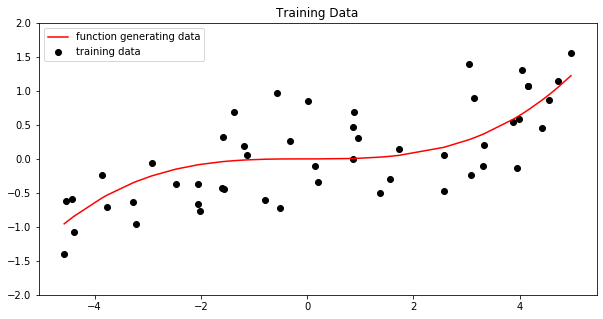

In [21]:
#number of training inputs
number_of_train_points = 50
#number of testing inputs
number_of_test_points = 100
#function generating our data
f = lambda x: 0.01 * x**3
#make training data
x_train, y_train, x_test, y_test = make_data(number_of_train_points, number_of_test_points, f)
#make test input that is evenly spaced over [-5, 5]
x_test = np.linspace(-5, 5, number_of_test_points)

#visualize training data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#plot training data
ax.scatter(x_train, y_train, color='black', label='training data')
#plot the underlying function generating the data
ax.plot(x_train, f(x_train), color='red', label='function generating data')
ax.set_title('Training Data')
ax.set_ylim([-2, 2])
plt.legend(loc='best')
plt.show()

Now, let's fit a degree 20 polynomial to our training data. Since this model is so flexible, it can use its extra degree of freedom to capture the noise in the data. As a result, when the training data changes slightly (when we resample the training data), the fitted polynomial will look drastically different. I.e. this model has high variance.

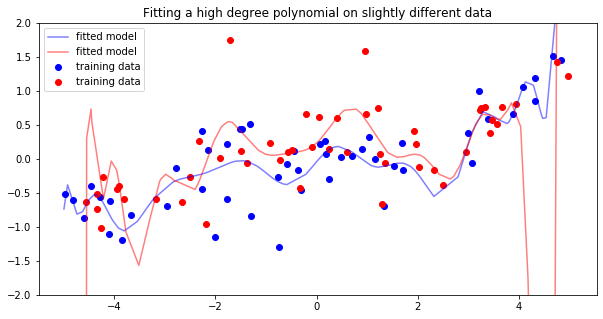

In [22]:
#instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features = PolynomialFeatures(20)
#instantiate a linear regression model
regression = LinearRegression()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = ['blue', 'red']

for i in range(2):
    #resample training and testing data
    x_train, y_train, x_test, y_test = make_data(number_of_train_points, number_of_test_points, f)
    #fit our polynomial model on the resampled data
    y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features, regression)
    #plot the resampled training data
    ax.scatter(x_train, y_train, color=colors[i], label='training data')
    #plot the fitted polynomial model
    ax.plot(x_test, y_predict, color=colors[i], alpha=0.5, label='fitted model')
    
ax.set_title('Fitting a high degree polynomial on slightly different data')
ax.set_ylim([-2, 2])
plt.legend(loc='best')
plt.show()

Now, let's repeat this $N$ times: that is, resample the training data $N$ times and train a degree polynomial on each resampled training data set (this is our "ensemble" of models). To make predictions on the test set, we average the predictions of all the models in our ensemble.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#plot a set of training data
ax.scatter(x_train, y_train, color='black', label='training data')

###
# FILL THIS IN
# train N number of degree polynomial models on N resampled training data set
# plot the predictions of each model you train on the test inputs
# average their predctions and plot the average
###

ax.set_title('Fitting an ensemble of high degree polynomials')
ax.set_ylim([-2, 2])
plt.legend(loc='best')
plt.show()

What do you notice about each of the models in your ensemble? What do you notice about their average?

In the `make_data` function, we resampled new training inputs from the interval $[-5, 5]$. When we do not have access to new data (e.g. collecting new data is prohibitively expensive), we need to create "new data" from our existing data. To do this, we bootstrap, that is, we sample different subsets from our existing data.

In the following, adapt the `make_data` function to bootstrap sample from an existing set of training inputs, `x_train`, and create your ensemble using these bootstrap samples.

def make_data(number_of_train_points, number_of_test_points, x, y):
    '''
    This function randomly samples training data from existing data x and y.
    
    number_of_train_points: number of training points to sample
    number_of_test_points: number of testing points to sample
    x: array of existing inputs
    y: array of existing labels 
    f: the underlying function relating x and y
    '''
    #randomly sample training data from x and y
    ###
    # FILL THIS IN
    ###
    return x_train, y_train

x = np.random.uniform(-5, 5, number_of_train_points)
y = f(x) + np.random.normal(0, 0.5, number_of_train_points)

What is the difference between building your ensemble from training data resampled from $[-5, 5]$ and training data bootstraped samples from an existing data set $x, y$? Is this what you expect?

# Bayesian Inference

(blackboard)

## Exploring the posterior of the parameters

In [ ]:
#sample training input
x_train = np.random.uniform(-5, 5, number_of_train_points)
#compute noisy label
y_train = f(x_train) + np.random.normal(0, 0.5, number_of_train_points)
#tranform training inputs into polynomial features
poly_x_train = polynomial_features.fit_transform(x_train.reshape((-1, 1)))
#tranform testing inputs into polynomial features
poly_x_test = polynomial_features.transform(x_test.reshape((-1, 1)))
    
#dimension of the weight vector is the number of polynomial features plus the bias
number_of_weights = 20 + 1

#defining a normal prior on weights
sigma = 0.5
prior_mean = np.zeros(number_of_weights)
prior_variance = sigma * np.eye(number_of_weights)

#the posterior over weights is a normal distribution
#posterior variance
posterior_variance = np.linalg.inv(1. / sigma * np.eye(number_of_weights) + poly_x_train.T.dot(poly_x_train)) 
#posterior mean
posterior_mean = posterior_variance.dot(poly_x_train.T.dot(y_train.reshape((-1, 1))) * 1. / sigma)

### Visualizing the posterior

What is the point of computing the posterior distribution $p(w| x, y)$ over weights rather than a point estimate of the 'best weight vector' for the data? Since we have a distribution for $w$, we can sample some weight vectors, each sample represents a different model for the data. In the following, visualize the functions from the posterior distribution.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#plot the training data
ax.scatter(x_train, y_train, color='black')
#number of samples from the posterior
number_of_samples = 100

###
# FILL THIS IN
# sample 100 w's from the posterior, visualize each w as a function over the test inputs
###

ax.set_title('Visualizing functions from the posterior')
ax.set_ylim([-2, 2])
plt.show()

What do you notice about the numerical issues involving computing the posterior variance analytically? What can we do to address these issues?

Change the prior for $w$ (vary the value for `sigma`), how does your choice of prior effect the posterior over $w$? Can you explain this effect?

Change the number of training data that you sample, how does the number of training data points effect the posterior over $w$? Can you explain this effect?


### Posterior Predictive
For each test input $x$, each $w$ sampled from the posterior will make a different prediction of the output $y$, thus, the posterior distribution of $w$ induces a distribution over predictions for test input $x$, this is the posterior predictive $p(y|x)$.

In the following, use samples from the posterior over $w$ to generate the posterior predictive distribution for a given input (say $x=2.5$). Visualize the posterior predictive distribution.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#number of samples from the posterior
number_of_samples = 500
#our test input
x_test = np.array([2.5])
#our test input transformed into polynomial features
poly_x_test = polynomial_features.fit_transform(x_test.reshape((-1, 1)))

###
# FILL THIS IN
# sample 500 w's from the posterior, use them to simulate the posterior predictive p(y|x) for x=2.5
# visualize the posterior predictive as a histogram
###

ax.set_title('Visualizing the posterior predictive')
plt.show()

Based on the posterior predictive distribution, what can you say about the predicted label for the input?

Can you list the pros and cons of computing point estimates for the model parameters and computing posterior distributions over parameters?

## Glossary

**Bias-Variance Tradeoﬀ**: When constructing machine learning models, we have a choice somewhere on a spectrum between two extremes: ﬁtting exactly to our training data or not varying in response to our training data at all. The ﬁrst extreme, ﬁtting all of our training data, is a situation of high variance, because our output changes heavily in reponse to our input data. At the other extreme, a solution that doesn’t change in response to our training data at all is a situation of high bias. This means our model heavily favors a speciﬁc form regardless of the training data, so our target outputs don’t ﬂuctuate between distinct training sets.

**Cross-Validation**: A subsampling procedure used over a data set to tune hyperparameters and avoid over-ﬁtting. Some portion of a data set (10-20% is common) is set aside, and training is performed on the remaining, larger portion of data. When training is complete, the smaller portion of data left out of training is used for testing. The larger portion of data is sometimes referred to as the training set, and the smaller portion is sometimes referred to as the validation set.

**Overﬁtting**: A phenomenon where we construct a convoluted model that is able to predict every point in our data set perfectly but which doesn’t generalize well to new data points.
 
**Underﬁtting**: A phenomenon where we construct a model that doesn’t re- spond to variation in our data.
  
**Generalization**: Generalization is the ability of a model to perform well on new data points outside of the training set.
 
**Regularization**: Applying penalties to parameters of a model.
